In [ ]:
import os
import mlflow
import optuna
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from typing import TypedDict
import matplotlib.pyplot as plt

c:\Users\bkarr\projects\agentic-hpt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
# Global Configurations
MODEL_VERSION = "v1.0"
MODEL_ACCURACY = 0.0
EXPERIMENT_NAME = "MLOps_Agent"
DATA_PATH = "../ml/data/diabetes_prediction_dataset.csv"

In [8]:
# Load Dataset
df = pd.read_csv(DATA_PATH)
df = pd.get_dummies(df, columns=['smoking_history', 'gender'])
X = df.drop(columns=["diabetes"])
y = df["diabetes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.2)

In [10]:
# Hyperparameter Optimization Function
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
    }
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

In [ ]:
# Train Initial Model
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
best_params = study.best_params
model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)
MODEL_ACCURACY = accuracy_score(y_test, model.predict(X_test))

In [12]:
# Log Model to MLflow
with mlflow.start_run():
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy", MODEL_ACCURACY)
    mlflow.xgboost.log_model(model, "model")

2025/06/29 17:08:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\bkarr\projects\agentic-hpt\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:08:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/29 17:08:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [29]:
# Define Workflow State Schema
class State(TypedDict):
    status: str  # Workflow status (e.g., "monitoring", "retraining")

In [ ]:
from langgraph.types import Command
from typing import Literal

# MLOps Workflow Functions
def model_perf(state: State) -> Command[Literal["decide", "__end__"]]:
    """Monitor model performance."""
    global MODEL_ACCURACY
    print(f"Monitoring Model: {MODEL_VERSION}, Accuracy: {MODEL_ACCURACY}")

    value = "drift_detected" if MODEL_ACCURACY < 0.75 else "model_healthy"
    goto = "decide_retraining" if value == "drift_detected" else "__end__"
    return Command(
        update={"status": value},
        goto=goto
    )

def decide_retrain(state: State) -> Command[Literal["retrain", "__end__"]]:
    """Decide if retraining is needed using an LLM."""
    response = llm.predict("The model accuracy dropped below the threshold. Should I retrain?")
    value = "retrain" if "yes" in response.lower() else "__end__"
    goto = "deploy" if value == "retrain" else "__end__"
    return Command(
        update={"status": value},
        goto=goto
    )

def retrain_model(state):
    """Retrain model with updated dataset & hyperparameters."""
    global MODEL_ACCURACY, MODEL_VERSION
    study.optimize(objective, n_trials=5)
    best_params = study.best_params
    new_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
    new_model.fit(X_train, y_train)
    MODEL_ACCURACY = accuracy_score(y_test, new_model.predict(X_test))
    MODEL_VERSION = "v" + str(int(MODEL_VERSION.split("v")[-1]) + 1)
    with mlflow.start_run():
        mlflow.log_params(best_params)
        mlflow.log_metric("new_accuracy", MODEL_ACCURACY)
        mlflow.xgboost.log_model(new_model, "model")
    return {"status": "deploy"}

def deploy_model(state):
    """Deploy the updated model."""
    print(f"Deploying Model {MODEL_VERSION} with Accuracy: {MODEL_ACCURACY}")
    return {"status": "__end__"}

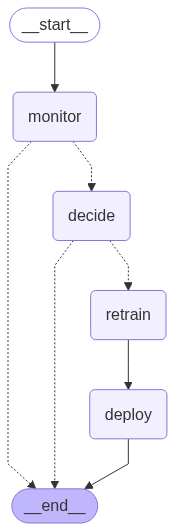

In [69]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("monitor", model_perf)
builder.add_node("decide", decide_retrain)
builder.add_node("retrain", retrain_model)
builder.add_node("deploy", deploy_model)

# Logic
builder.add_edge(START, "monitor")
builder.add_edge("retrain", "deploy")
builder.add_edge("deploy", END)


# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))